# Mean-variance estimators

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import Image, display

A portfolio is the ownership of a set of securities that give rights to a stream of payments. The goal of Markowitz portfolio optimisation is to determine the portfolio holdings that maximise the expected return of the portfolio under a risk constraint. Mathematically, it boils down to maximising a "mean-variance objective". In this section, we review the mathematics of Markowitz portfolio optimisation and how to implement in `python` "mean-variance optimisers" that follow the scikit-learn "fit/predict" API. 

## Markowitz portfolio optimisation

The portfolio universe is made of $N$ assets: 

- $r$ is a vector of returns for each asset (with size $N$); 

- $\alpha$ is the asset return forecast: $\alpha = E(r)$; 

- $V$ is the return covariance matrix that measures that correlation between each asset: $V = Var(r)$; 

- $h$ is a vector of positions/holdings in each of these assets. 

Note: for a vector $v$, we denote $v^T$ as the transpose of $v$. 

A mean-variance objective is an objective that trades off the portfolio expected return (as $h^T \alpha$) against the portfolio expected risk (as $h^T V h$). In practice, it is written as: 

$$U = h^T \alpha - \frac{h^T V h}{2 \lambda},$$

where $\lambda$ is the risk-tolerance.


**Lemma** [mean-variance]: the allocation $h$ that maximizes the mean-variance objective is
$$h = \lambda V^{-1} \alpha. $$

The ex-ante risk is $h^T V h = \lambda^2 \alpha^T V^{-1} \alpha$ and the ex-ante Sharpe ratio is
$$
S = \frac{h^T E(r)}{\sqrt{h^T V h}} = \sqrt{\alpha^T V^{-1} \alpha}. 
$$

**Corollary**: The maximisation of the sharpe ratio is equivalent (up to a scaling factor) the mean-variance optimisation. 

The mean-variance formula is extended to account for the linear constraints
$$A h = b. $$ 

To do so, we introduce the Lagrangian $\mathcal {L}$ (and Lagrange multiplier $\xi$)

$$
\mathcal {L}= h^T \alpha - \frac{h^T V h}{2\lambda} - (h^T A^T - b^T)\xi
$$

The Lagrange multiplier $\xi$ is a `tuning parameter` chosen exactly so that the constraint above holds. At the optimal value of $\xi$, the constrained problem boils down to an unconstrained problem with the adjusted return forecast $\alpha - A^T \xi$.


**Lemma**: the allocation that maximizes the objective $h^T \alpha - \frac{h^T V h}{2 \lambda}$ under the linear constraint $A h = b$ is

$$ h = V^{-1} A^T \left(A V^{-1} A^T \right)^{-1} b + \lambda V^{-1} \left[\alpha - A^T \left(A V^{-1} A^T \right)^{-1} A V^{-1} \alpha \right]$$

*Proof*: the first-order condition is

$$ \frac{\partial \mathcal {L}}{\partial h} = \alpha - \frac{V h}{\lambda} - A^T \xi =0  \Leftrightarrow  h = \lambda V^{-1}[\alpha - A^T \xi] $$

The parameter $\xi$ is chosen so that $A h = b$

$$b = Ah = \lambda A  V^{-1}[\alpha - A^T \xi]  \Rightarrow  \xi = [A V^{-1}A^T]^{-1} \left[ A  V^{-1}\alpha - \frac{b}{\lambda}  \right]
$$

The holding vector under constraint is

$$ h_{\lambda} = \underbrace {V^{-1} A^T \left(A V^{-1} A^T \right)^{-1} b}_{\text {minimum variance portfolio}} + \underbrace { \lambda V^{-1} \left[\alpha - A^T \left(A V^{-1} A^T \right)^{-1} A V^{-1} \alpha \right]}_{\text {speculative portfolio}} $$

- The first term is what minimises the risk $h^T V h$ under the constraint $Ah =b$ (in particular, it does not depend on expected returns or risk-tolerance).

- The second term is the speculative portfolio (it is sensitive to both inputs).

The efficient frontier is the relation between  expected portfolio return $h^T \alpha$ and portfolio standard deviation $\sqrt{h^T V h}$ for varying level of risk-tolerance
$$ (x, y) \mapsto \left(h_{\lambda}^T \alpha, \sqrt{h_{\lambda}^T V h_{\lambda}} \right)$$

When $b=0$, the efficient frontier between $h_{\lambda}^T \alpha$ and $\sqrt{h_{\lambda}^T V h_{\lambda}}$ is a line through $(0,0)$; otherwise, it is a parabolic curve.

We focus on pure "alpha views" -- that is, long-short "cash-neutral" portfolios where the sum of holdings is zero. In this case $b=0$ and $A = \textbf{1}$ where

$$ \textbf {1} = \left[\begin {array}{ccc} 1  & \ldots & 1  \end {array} \right].$$

## A shortcut to compute unconstrained mean-variance weights

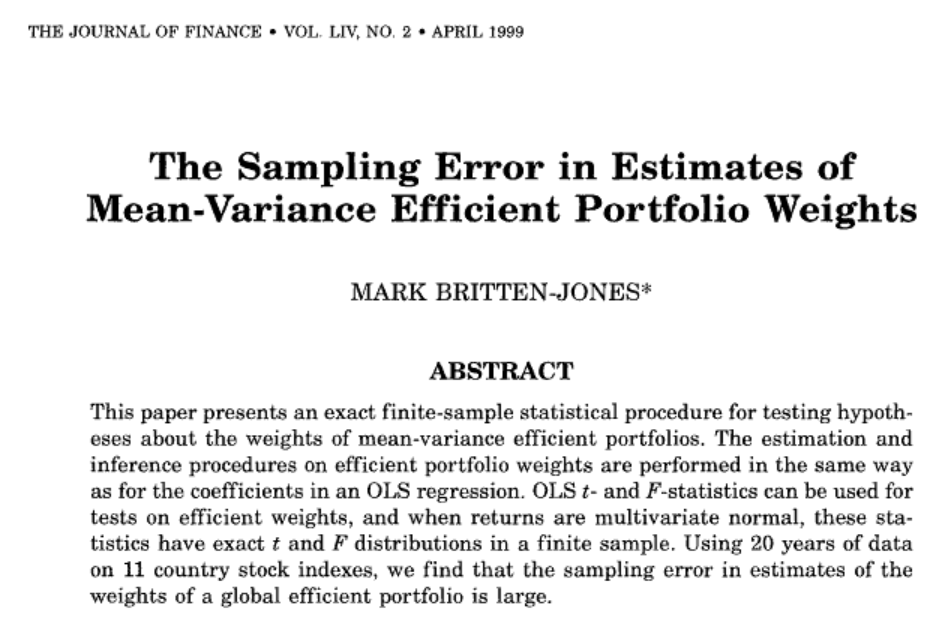

In [2]:
# hide
display(Image("images/mbj.png", width=500))

In this section, we derive a trick to compute unconstrained mean-variance weights just with the return of different assets. More precisely: 

- X: daily return of $K$ assets over $T$ days -- so that the shape of X is $[T \times K]$. 

- y: vector of ones of size $T$. 

**Lemma** [Mark Britten-Jones]: the markowitz weights of are proportional to the slope coefficient of a regression of the vector of ones $y$ on the pnls $X$ *with no intercept*. 

Proof: the coefficient of the regression with no intercept is given by 

$$ b = (X^T X)^{-1} X^T y.  $$

The mean of the pnls is given by $\mu = \frac{1}{T} X^T y$. The variance of the pnls is $V = \frac{1}{T} X^T X - \mu \mu^T$

Using the Woodbury identity (https://en.wikipedia.org/wiki/Woodbury_matrix_identity), we have: 

$$ b = (V + \mu \mu^{T})^{-1} \mu = \left[ V^{-1} -  \frac{V^{-1} \mu \mu^{T}V^{-1}}{1 + \mu^T V^{-1} \mu}  \right] \mu = \frac{V^{-1} \mu}{1 + \mu^T V^{-1} \mu}. $$

This implies that the OLS slope coefficient $b$ is proportial to the mean-variance holdings $V^{-1}\mu$. 

## Mean-variance estimators

In the following python file, we introduce several functions: 

- a function that computes mean-variance holdings for batches

- a `MeanVariance` class that follows the `sklearn` api

- a `Mbj` class that computes unconstrained mean-variance weights with the Britten-Jones (1999) trick. 

In [3]:
%%writefile ../skfin/mv_estimators.py
import numpy as np
import pandas as pd
from skfin.metrics import sharpe_ratio
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

from dataclasses import dataclass, field
from typing import Callable, Optional


def compute_batch_holdings(pred, V, A=None, risk_target=None):
    """
    compute markowitz holdings with return prediction "mu" and covariance matrix "V"

    Args: 
        pred: (numpy.ndarray or pandas.Series or pandas.DataFrame): Expected returns, can be of shape (N,) or (N, K).
        V: (numpy.ndarray): Covariance matrix of shape (N, N).
        A: (numpy.ndarray, optional): Matrix for linear constraints, default is None
        past_h (numpy.ndarray, optional): Not used in the current implementation.
        constant_risk (bool, optional): If True, normalize outputs to maintain constant risk, default is False.

    Returns:
        numpy.ndarray: Computed holdings.
    """

    N, _ = V.shape
    if isinstance(pred, (pd.Series, pd.DataFrame)):
        pred = pred.values
    if pred.ndim == 1:
        pred = pred[:, np.newaxis]
    elif pred.shape[1] == N:
        pred = pred.T

    invV = np.linalg.inv(V)
    if A is None:
        M = invV
    else:
        U = invV.dot(A)
        if A.ndim == 1:
            M = invV - np.outer(U, U.T) / U.dot(A)
        else:
            M = invV - U.dot(np.linalg.inv(U.T.dot(A)).dot(U.T))
    h = M.dot(pred)
    if risk_target is not None:
        h = risk_target * h / np.sqrt(np.diag(h.T.dot(V.dot(h))))
    return h.T



@dataclass
class MeanVariance(BaseEstimator):
    """
    A mean-variance optimization estimator that computes portfolio holdings 
    based on expected returns and the covariance matrix.

    Attributes:
        transform_V (Callable): Function to transform target variable 'y' into a covariance matrix.
        A (Optional[np.ndarray]): Constraints matrix for the optimization problem.
        risk_target (float): Risk target for the portfolio.
    """
    transform_V: Callable = field(default=lambda x: np.cov(x.T))
    A: Optional[np.ndarray] = None
    risk_target: float = 1.0

    def __post_init__(self):
        """
        Post-initialization process to set additional attributes or setup.
        """
        self.holdings_kwargs = {'risk_target': self.risk_target}
    
    @staticmethod
    def compute_batch_holdings(pred, V, A, risk_target, **kwargs):
        """
        Compute portfolio holdings in a batch manner.

        Parameters:
            pred (np.ndarray): Predicted returns.
            V (np.ndarray): Covariance matrix.
            A (np.ndarray): Constraint matrix.
            risk_target (float): Target risk level.
            **kwargs: Additional keyword arguments.

        Returns:
            np.ndarray: Portfolio holdings.
        """
        return compute_batch_holdings(pred=pred, V=V, A=A, **kwargs)
    
    def fit(self, X, y=None):
        """
        Fit the model by calculating the covariance matrix 'V_' from targets 'y'.

        Parameters:
            X (np.ndarray): Input feature matrix.
            y (np.ndarray): Target variable matrix.
        """
        self.V_ = self.transform_V(y)

    def predict(self, X, **kwargs):
        """
        Predict portfolio holdings based on input features.

        Parameters:
            X (np.ndarray): Input feature matrix.
            **kwargs: Additional keyword arguments.

        Returns:
            np.ndarray: Predicted portfolio holdings.
        """
        A = self.A if self.A is not None else np.ones(X.shape[1])
        kwargs = {**kwargs, **self.holdings_kwargs}
        h = self.compute_batch_holdings(pred=X, V=self.V_, A=A, **kwargs)
        return h
        
    def score(self, X, y):
        """
        Calculate the performance score of the portfolio using Sharpe ratio.

        Parameters:
            X (np.ndarray): Predicted returns.
            y (np.ndarray): Actual returns.

        Returns:
            float: Sharpe ratio of the portfolio.
        """
        return sharpe_ratio(np.sum(X * y, axis=1))


class Mbj(TransformerMixin):
    """
    Computing unconstrained mean-variance weights with the Britten-Jones (1999) trick.
    """

    def __init__(self, positive=False):
        self.positive = positive

    def fit(self, X, y=None):
        m = LinearRegression(fit_intercept=False, positive=self.positive)
        m.fit(X, y=np.ones(len(X)))
        self.coef_ = m.coef_ / np.sqrt(np.sum(m.coef_**2))
        return self

    def transform(self, X):
        return X.dot(self.coef_)


class TimingMeanVariance(BaseEstimator):
    def __init__(self, transform_V=None, a_min=None, a_max=None):
        if transform_V is None:
            self.transform_V = lambda x: np.var(x)
        else:
            self.transform_V = transform_V
        self.a_min = a_min
        self.a_max = a_max

    def fit(self, X, y=None):
        self.V_ = self.transform_V(y)

    def predict(self, X):
        if (self.a_min is None) & (self.a_max is None):
            h = X / self.V_
        else:
            h = np.clip(
                X / np.sqrt(self.V_), a_min=self.a_min, a_max=self.a_max
            ) / np.sqrt(self.V_)
        return h

Overwriting ../skfin/mv_estimators.py


In [4]:
from skfin.datasets_ import load_kf_returns
from skfin.mv_estimators import MeanVariance, compute_batch_holdings

returns_data = load_kf_returns(cache_dir="data", force_reload=True)
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

INFO:skfin.dataloaders.cache:Loading from an external source


INFO:skfin.dataloaders.cache:Sauvegarde dans le cache : data/12_Industry_Portfolios


In [5]:
T, N = ret.shape
A = np.ones(N)

h = compute_batch_holdings(ret.mean(), ret.cov(), A)

np.allclose(h.dot(A), [0.0])

True

In [6]:
A = np.stack([np.ones(N), np.zeros(N)], axis=1)
A[0, 1] = 1

h = compute_batch_holdings(pred=ret.mean(), V=ret.cov(), A=A)

## Pnl metrics

The performance  of a strategy is evaluated through the profit-and-loss (pnl). The time convention is:
    
- holdings $h_t$ and returns $r_t$ are known for period $t$ -- ie. at the end of period $t$.

- so to compute pnl with forward-looking information, the holdings must only depend on information up to $t-1$

- in practice, we will have

$$ pnl_t = h_{t-1} \times r_t. $$

First, the measure that captures the gain of a strategy $E[pnn_t]$ for a level of risk $Var[pnl_t]$ is given by the Sharpe ratio: 
    
$$sr = \sqrt{N_{\text{periods per year}}} \times \frac{E[pnl_t]}{\sqrt{Var[pnl_t]}}, $$

where $N_{\text{periods per year}}$ is an annualization factor that accounts for the number of observation per year (e.g. 12 for a monthly strategy, 260 for a strategy with pnls only on business days). 

In [7]:
%%writefile ../skfin/metrics.py
import numpy as np


def test_monthly(df):
    return int(len(df) / len(df.asfreq("M"))) == 1


def test_bday(df):
    return int(len(df) / len(df.asfreq("B"))) == 1


def test_day(df):
    return int(len(df) / len(df.asfreq("D"))) == 1


def sharpe_ratio(df, num_period_per_year=None, remove_zeros=True):
    if num_period_per_year is None: 
        if test_monthly(df):
            num_period_per_year = 12
        if test_bday(df):
            num_period_per_year = 260
        if test_day(df):
            num_period_per_year = 365
        if num_period_per_year is None:
            return np.nan
    if remove_zeros: 
        df = df.replace(0, np.nan)
    return df.mean() / df.std() * np.sqrt(num_period_per_year)


def drawdown(x, return_in_risk_unit=True, window=36, num_period_per_year=12):
    dd = x.cumsum().sub(x.cumsum().cummax())
    if return_in_risk_unit:
        return dd.div(x.rolling(window).std().mul(np.sqrt(num_period_per_year)))
    else:
        return dd

Overwriting ../skfin/metrics.py
